In [52]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def display_tensor(tensor):
    """Displays a tensor"""
    plt.imshow(tensor,  cmap='gray', interpolation='none')
    # display(torchvision.transforms.ToPILImage()(tensor))

In [36]:
# Transform pipeline: The data that comes back is in MNIST format. We want to transform
# it into normalized tensors for later computation
transform_pipeline = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])


# Set up the data sources
train_data = torchvision.datasets.MNIST('data/', train=True, download=True, transform=transform_pipeline)
test_data = torchvision.datasets.MNIST('data/', train=False, download=True, transform=transform_pipeline)

# Set up data loaders (samplers + the data set)
train_loader = torch.utils.data.DataLoader(train_data)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=True)

In [69]:
class Autoencoder(torch.nn.Module):
    def __init__(self, input_shape, latent_size, hidden_size=128):
        super().__init__()
        self.encoder_hidden = torch.nn.Linear(in_features=input_shape, out_features=hidden_size)
        self.encoder_output = torch.nn.Linear(in_features=hidden_size, out_features=latent_size)

        self.decoder_hidden = torch.nn.Linear(in_features=latent_size, out_features=hidden_size)
        self.decoder_output = torch.nn.Linear(in_features=hidden_size, out_features=input_shape)

        
    def encode(self, x):
        """Encode using the encoder portion of the auto encoder."""
        x = self.encoder_hidden(x)
        x = torch.relu(x)
        x = self.encoder_output(x)
#         x = torch.relu(x)
        return x
    
    def decode(self, x):
        """Decode using the decoder portion of the auto encoder."""
        x = self.decoder_hidden(x)
        x = torch.relu(x)
        x = self.decoder_output(x)
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        """Run the entire auto encoder/decoder pair together."""
        code = self.encode(x)
        reconstructed = self.decode(code)
        return reconstructed

In [70]:
model = Autoencoder(input_shape=28*28, latent_size=2, hidden_size=128)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # TODO: Research the optimizer.
criterion = torch.nn.MSELoss()
epochs = 2

# model.load_state_dict(torch.load('model-data2.pkl'))

In [71]:
for epoch in range(epochs):
    loss = 0
    for i, (batch_features, _) in enumerate(train_loader):
        batch_features = batch_features.view(-1, 784)
        optimizer.zero_grad()
        
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
        
        if i % 10000 == 0:
            print(i)
        
    
    loss = loss / len(train_loader)
    
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

0
10000
20000
30000
40000
50000
epoch : 1/2, loss = 0.046583
0
10000
20000
30000
40000
50000
epoch : 2/2, loss = 0.043876


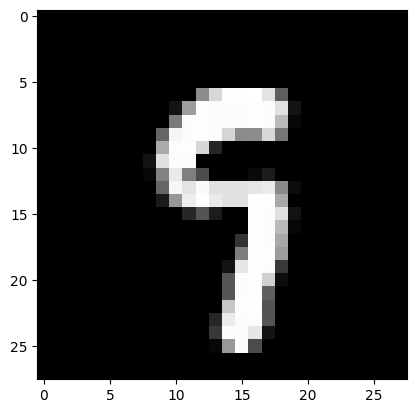

In [72]:
d = next(enumerate(test_loader))[1][0][0]
reconstructed = model(d.view(-1, 28 *28))
display_tensor(d.view(28,28))


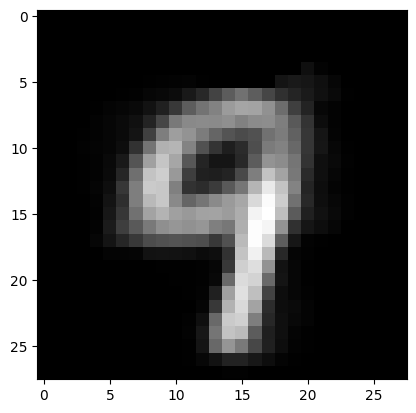

In [73]:
# test_latent_spaces = []
# for _, (batch_features, _) in enumerate(test_loader):
#     batch_features = batch_features.view(-1, 784)
#     latent = model.encode(batch_features)
#     test_latent_spaces.append(latent)
    


# base = model.encode(d.view(-1, 28 *28))

# print(torch.count_nonzero(base))

# print(base)

# delta = torch.zeros(128)


display_tensor(model.decode(model.encode(d.view(-1, 28 *28))).view(28, 28).detach())


# torch.save(model.state_dict(), 'model-data2.pkl')

In [78]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encode(x.view(-1, 28 * 28))
        z = z.detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            break
    plt.colorbar()
            
def plot_reconstructed(autoencoder, r0=(-5, 15), r1=(-5, 30), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decode(z)
            x_hat = x_hat.reshape(28, 28).detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

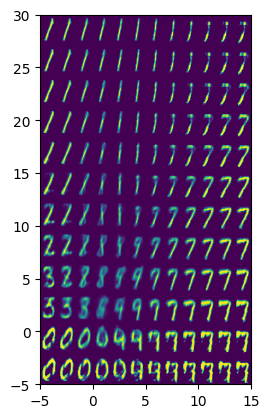

In [79]:
# plot_latent(model, test_loader, num_batches=100)
plot_reconstructed(model)

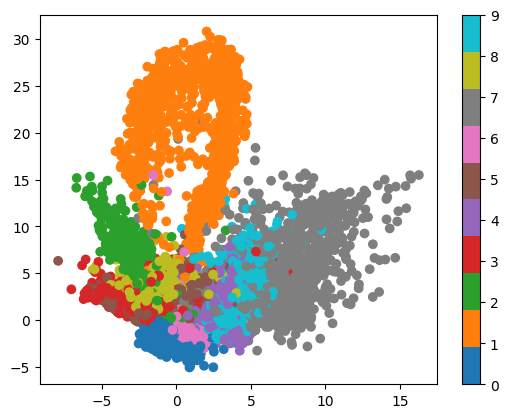

In [80]:
plot_latent(model, test_loader, num_batches=100)

In [82]:
# Now let's make it variational
class VariationalAutoencoder(torch.nn.Module):
    def __init__(self, input_shape, latent_size, hidden_size=128):
        super().__init__()
        self.encoder_hidden = torch.nn.Linear(in_features=input_shape, out_features=hidden_size)
        self.encoder_output_mu = torch.nn.Linear(in_features=hidden_size, out_features=latent_size)
        self.encoder_output_sigma = torch.nn.Linear(in_features=hidden_size, out_features=latent_size)

        
        self.decoder_hidden = torch.nn.Linear(in_features=latent_size, out_features=hidden_size)
        self.decoder_output = torch.nn.Linear(in_features=hidden_size, out_features=input_shape)

        
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0 # I don't really understand KL loss...
        
    def encode(self, x):
        """Encode using the encoder portion of the auto encoder."""
        x = self.encoder_hidden(x)
        x = torch.relu(x)
        
        mu =  self.encoder_output_mu(x)
        sigma = torch.exp(self.encoder_output_sigma(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z
    
    def decode(self, x):
        """Decode using the decoder portion of the auto encoder."""
        x = self.decoder_hidden(x)
        x = torch.relu(x)
        x = self.decoder_output(x)
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        """Run the entire auto encoder/decoder pair together."""
        code = self.encode(x)
        reconstructed = self.decode(code)
        return reconstructed

In [89]:
modelVA = VariationalAutoencoder(input_shape=28*28, latent_size=4, hidden_size=128)
optimizer = torch.optim.Adam(modelVA.parameters(), lr=1e-3) 
criterion = torch.nn.MSELoss()
epochs = 2

In [90]:
for epoch in range(epochs):
    loss = 0
    for i, (batch_features, _) in enumerate(train_loader):
        batch_features = batch_features.view(-1, 784)
        optimizer.zero_grad()
        
        outputs = modelVA(batch_features)
        train_loss = criterion(outputs, batch_features) + modelVA.kl
        train_loss.backward()
        
        optimizer.step()
        
        loss += train_loss.item()
        
        if i % 10000 == 0:
            print(i)
        
    
    loss = loss / len(train_loader)
    
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

0
10000
20000
30000
40000
50000
epoch : 1/2, loss = 1.454131
0
10000
20000
30000
40000
50000
epoch : 2/2, loss = 1.453395


In [91]:
display_tensor(modelVA.decode(model.encode(d.view(-1, 28 *28))).view(28, 28).detach())
# display_tensor(d.view(28, 28))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 4x128)